# Pt.3 Modeling 

Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

In [1]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

import warnings
warnings.filterwarnings('ignore')


# Basic EDA

In [2]:
# import dataset of interest 
users_df = pd.read_json('ultimate_data_challenge.json')

In [3]:
users_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [4]:
# examine datatypes 

users_df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [5]:
# check for missing values 

users_df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [6]:
# examine descriptive stats

users_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


Looks like we need to convert some datatypes and address some missing values 

# Munging

In [7]:
# convert 'signup_date' and 'last_trip_date' columns to datetime objecs 

users_df.signup_date = pd.to_datetime(users_df.signup_date)
users_df.last_trip_date = pd.to_datetime(users_df.last_trip_date)

In [8]:
# examine 'phone' column

users_df.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

There are two types of phone (iPhone + Andriod) as well as some missing values. We will make a new value for missing phone type called 'unknown'

In [9]:
# lambda function to convert missing phone values to 'unknown' 

users_df['phone'] = users_df.phone.apply(lambda x: 'Unknown' if type(x) != str else x)

Now we need to address the missing values for the two ratings columns. The number of missing ratings is relatively small and will be replaced by the mean value for the respective column. 

<AxesSubplot:>

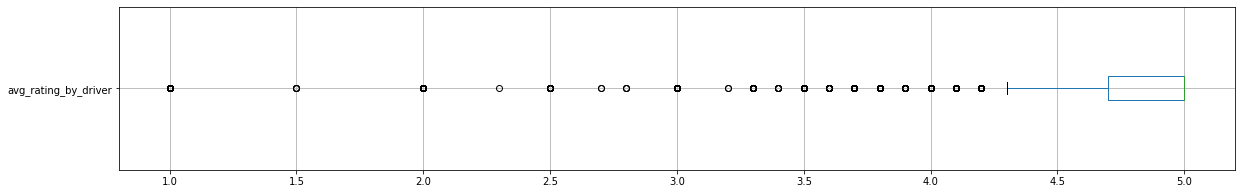

In [10]:
# box plot showing distribution of ratings given to riders by drivers

users_df.boxplot(column='avg_rating_by_driver', figsize=(20,3), vert=False)

<AxesSubplot:>

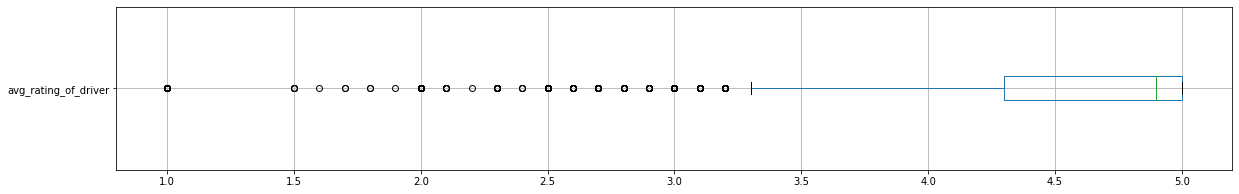

In [11]:
# box plot showing distribution of ratings given to drivers by riders

users_df.boxplot(column='avg_rating_of_driver', figsize=(20,3), vert=False)

The ratings scale is limited to a score between 1-5. This prevents any extreme outlier from skewing our data. 

In [12]:
print(f'The average rating given to a rider by a driver is {users_df.avg_rating_by_driver.mean()}')
print(f'The mdeian rating given to a rider by a driver is {users_df.avg_rating_by_driver.median()}')

print(' ')

print(f'The average rating given to a driver by a rider is {users_df.avg_rating_of_driver.mean()}')
print(f'The median rating given to a driver by a rider is {users_df.avg_rating_of_driver.median()}')


The average rating given to a rider by a driver is 4.778158195947439
The mdeian rating given to a rider by a driver is 5.0
 
The average rating given to a driver by a rider is 4.6015592912744685
The median rating given to a driver by a rider is 4.9


The means and medians for ratings are relatively close, the difference between imputing with mean vs. median is nominal. I will impute missing ratings values with the means. 

In [13]:
# replace missing numeric values with means 

avg_rating1 = users_df.avg_rating_by_driver.mean()
users_df.avg_rating_by_driver = users_df.avg_rating_by_driver.fillna(avg_rating1)

avg_rating2 = users_df.avg_rating_of_driver.mean()
users_df.avg_rating_of_driver = users_df.avg_rating_of_driver.fillna(avg_rating2)

<AxesSubplot:>

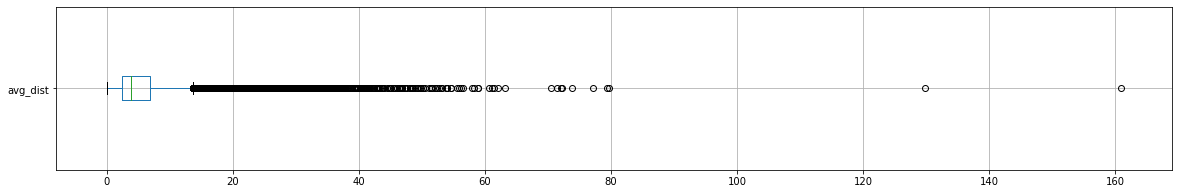

In [295]:
# check for outliers in the 'trips_in_first_30_days' column 

users_df.boxplot(column='avg_dist', figsize=(20,3), vert=False)

In [298]:
users_df[users_df['avg_dist'] > 80]

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Unknown,phone_iPhone,active
534,0.0,2014-01-04,4.601559,1.0,2014-03-09,0.0,0,0.0,129.89,5.000000,0,1,0,0,1,0,0
20701,0.0,2014-01-25,4.601559,1.0,2014-06-26,0.0,0,100.0,160.96,4.778158,1,0,0,1,0,0,1


<AxesSubplot:>

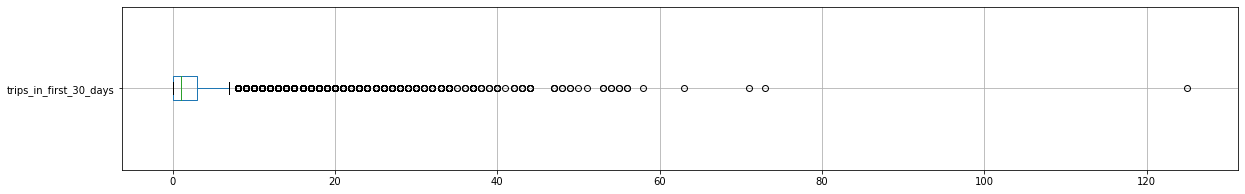

In [14]:
# check for outliers in the 'trips_in_first_30_days' column 

users_df.boxplot(column='trips_in_first_30_days', figsize=(20,3), vert=False)

There's one outlying value of 125 for trips taken in the first month. This seems unlikely. It would be hard to take 125 trips in 30 days. That would be ~4 trips every single day for 30 days. 

In [15]:
# replace outlier with the mean 

mean = users_df['trips_in_first_30_days'].mean()

users_df['trips_in_first_30_days'] = users_df['trips_in_first_30_days'].apply(lambda x: mean if x == 125 else x)

In [16]:
# check to see that we have no missing values 

users_df.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

Let's convert the 'ultimate_black_user' column into an binary numeric data type

In [17]:
# lambda function to convert binary bool to int

users_df['ultimate_black_user'] = users_df.ultimate_black_user.apply(lambda x: 1 if x==True else 0)

In [18]:
# examine city column 

users_df.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

The 'city' and 'phone' columns are text-based 'object' datatypes, let's make them numeric with a method called 'dummy encoding' 

In [ ]:
# first let's make a copy for safekeeping 

df_user_info = users_df.copy()

In [19]:
# dummy encode city column 

users_df = pd.get_dummies(users_df, columns=['city', 'phone'], dtype=int)

In [20]:
# examine updated datatypes

users_df.dtypes

trips_in_first_30_days           float64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
surge_pct                        float64
ultimate_black_user                int64
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
city_Astapor                       int64
city_King's Landing                int64
city_Winterfell                    int64
phone_Android                      int64
phone_Unknown                      int64
phone_iPhone                       int64
dtype: object

Everything is numeric except for our dates! 

In [21]:
users_df

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Unknown,phone_iPhone
0,4.0,2014-01-25,4.700000,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,0,1,0,0,0,1
1,0.0,2014-01-29,5.000000,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,1,0,0,1,0,0
2,3.0,2014-01-06,4.300000,1.00,2014-01-07,0.0,0,100.0,0.77,5.0,1,0,0,0,0,1
3,9.0,2014-01-10,4.600000,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,0,1,0,0,0,1
4,14.0,2014-01-27,4.400000,1.19,2014-03-15,11.8,0,82.4,3.13,4.9,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.0,2014-01-25,5.000000,1.00,2014-06-05,0.0,0,100.0,5.63,4.2,0,1,0,0,0,1
49996,1.0,2014-01-24,4.601559,1.00,2014-01-25,0.0,0,0.0,0.00,4.0,1,0,0,0,0,1
49997,0.0,2014-01-31,5.000000,1.00,2014-05-22,0.0,1,100.0,3.86,5.0,0,0,1,1,0,0
49998,2.0,2014-01-14,3.000000,1.00,2014-01-15,0.0,0,100.0,4.58,3.5,1,0,0,0,0,1


Now, let's add a target varible column: whether or not the rider was 'active'

In [22]:
# view the earliest and lates possible trip dates (the span of our dataset)

users_df.last_trip_date.sort_values(ascending=False)

4486    2014-07-01
43047   2014-07-01
24059   2014-07-01
40290   2014-07-01
28689   2014-07-01
           ...    
23907   2014-01-01
47804   2014-01-01
11578   2014-01-01
11573   2014-01-01
15359   2014-01-01
Name: last_trip_date, Length: 50000, dtype: datetime64[ns]

In [23]:
# add target variable 
# make column to represent whether or not a user has been active in the last 30 days (from June 1 to July 1) since the data was pulled

from datetime import timedelta

latest_date = users_df['last_trip_date'].max()

users_df['active'] = users_df['last_trip_date'].apply(lambda x: 1 if (latest_date - x < timedelta(days=31))  else 0)


# More EDA 

In [475]:
# Did everyone sign up during January ?

len(users_df[users_df['signup_date'].dt.month == 1])

# Yes 

50000

In [650]:
# How many people only used the service within the month they signed up (Jan) and took only 1 or 2 trips? 

len(users_df[ (users_df['last_trip_date'].dt.month == 1) & (users_df['trips_in_first_30_days'] < 3) ])

8692

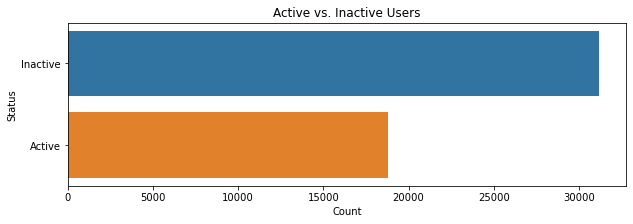

In [1552]:
# examine total count of active vs inactive users

fig, ax = plt.subplots(figsize=(10,3))
ax = sns.countplot(y='active', data=users_df)
ax.set(xlabel= 'Count', ylabel= 'Status', title="Active vs. Inactive Users")
ax.set_yticklabels(['Inactive', 'Active' ])
        
plt.show()

In [27]:
print(f'There are {len(users_df[users_df["active"]== 1])} active users and {len(users_df[users_df["active"]== 0])} inactive users')

There are 18804 active users and 31196 inactive users


In [28]:
# calculate proportion of users that are active vs inactive 

active = len(users_df[users_df['active'] == 1]) / len(users_df) * 100
inactive = len(users_df[users_df['active'] == 0]) / len(users_df) * 100

print(f'{round(active, 2)} % of all users are active')
print(f'{round(inactive, 2)} % of all users are inactive')

37.61 % of all users are active
62.39 % of all users are inactive


<AxesSubplot:>

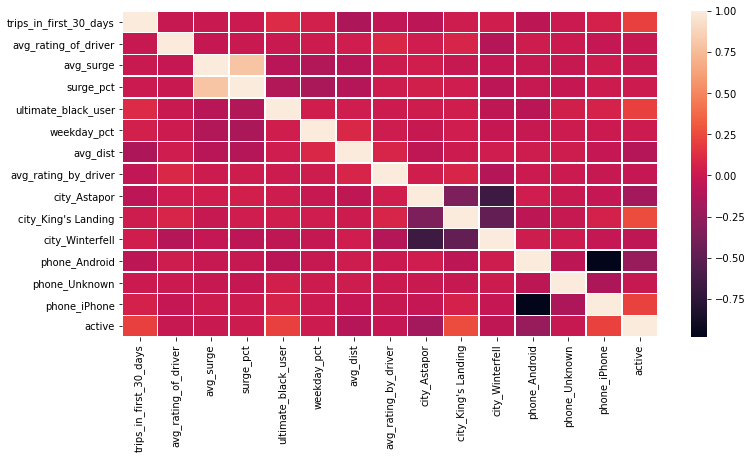

In [29]:
# explore some possible correlations 

fig, ax = plt.subplots(figsize=(12,6))

sns.heatmap(users_df.corr(), linewidths=.5, ax=ax)

Based on the heatmap there seems to be some *slight* positive correlation between retention and 'trips in the first 30 days', 'ultimate black user', 'King's Landing city' and 'iPhone user'

In [474]:
# examine descriptive stats for ONLY active users

actives_df = users_df[users_df['active'] == 1]
actives_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Unknown,phone_iPhone,active
count,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.0
mean,3.299791,4.593679,1.073809,9.152797,0.505052,61.389034,5.114788,4.762801,0.224846,0.338385,0.436769,0.167305,0.007073,0.825622,1.0
std,4.907139,0.518319,0.163170,15.588704,0.499988,29.487584,4.615175,0.328175,0.417492,0.473173,0.495999,0.373258,0.083805,0.379444,0.0
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,4.400000,1.000000,0.000000,0.000000,44.400000,2.560000,4.700000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
50%,2.000000,4.700000,1.000000,0.000000,1.000000,64.300000,3.730000,4.800000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
75%,4.000000,5.000000,1.090000,13.300000,1.000000,84.600000,5.890000,5.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.0
max,71.000000,5.000000,4.500000,100.000000,1.000000,100.000000,160.960000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [471]:
# examine descriptive stats for ONLY inactive users

inactives_df= users_df[users_df['active'] == 0]
inactives_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Unknown,phone_iPhone,active
count,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.0
mean,1.658482,4.606309,1.075339,8.666739,0.299942,60.647032,6.207939,4.787415,0.394474,0.120753,0.484774,0.380690,0.008431,0.610880,0.0
std,2.654222,0.591282,0.251361,22.179139,0.458240,40.982688,6.238675,0.503312,0.488745,0.325845,0.499776,0.485564,0.091432,0.487559,0.0
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,4.500000,1.000000,0.000000,0.000000,16.700000,2.320000,4.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,1.000000,4.800000,1.000000,0.000000,0.000000,69.600000,4.030000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
75%,2.000000,5.000000,1.000000,0.000000,1.000000,100.000000,7.800000,5.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.0
max,73.000000,5.000000,8.000000,100.000000,1.000000,100.000000,129.890000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [630]:
#filter dataset to show only users who took 0 trips in the first 30 days

df_numeric[ df_numeric['trips_in_first_30_days'] == 0 ]


,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Unknown,phone_iPhone,active
1,0.0,5.000000,1.00,0.0,0,50.0,8.26,5.0,1,0,0,1,0,0,0
13,0.0,4.000000,1.38,50.0,0,50.0,3.04,5.0,0,1,0,0,0,1,1
17,0.0,3.900000,1.00,0.0,1,95.2,2.38,4.8,0,1,0,0,0,1,1
19,0.0,5.000000,1.17,33.3,0,66.7,12.08,5.0,0,1,0,0,0,1,1
22,0.0,4.601559,1.00,0.0,0,100.0,11.47,5.0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49986,0.0,4.000000,1.00,0.0,0,100.0,0.52,5.0,0,0,1,1,0,0,0
49991,0.0,5.000000,1.25,100.0,0,0.0,1.06,5.0,0,0,1,0,0,1,1
49995,0.0,5.000000,1.00,0.0,0,100.0,5.63,4.2,0,1,0,0,0,1,1
49997,0.0,5.000000,1.00,0.0,1,100.0,3.86,5.0,0,0,1,1,0,0,0


Potential data discrepancy: 

The description of the dataset says that 'avg_dist' is the average distance per trip taken in the first 30 days. So if the amount of trips taken in the first 30 days is 0, then the average distance should also be 0. We can see in the data set above that's not the case. 

Either the description in the prompt is wrong and 'avg_dist' is calculated over a larger time period or the data has quality issues and one of those two columns (avg_dist & trips_in_first_30_days) contains faulty data. 



# Preprocessing

In [402]:
# drop date columns, resulting in a numeric dataset 

df_numeric = users_df.copy()
df_numeric.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)

In [853]:
# import preprocessing library and various tools 

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


In [665]:
# break off the dependent 'target' variable from the independent 'predictor' varibales 

X_independents = df_numeric.drop(['active'], axis=1)
y_target = df_numeric.active


In [742]:
# train/test split the data 

X_train, X_test, y_train, y_test = train_test_split(X_independents, y_target, test_size=.20, random_state=22)

# Modeling with Logistic Regression


In [ ]:
# import logistic regression algorithm 

from sklearn.linear_model import LogisticRegression

In [832]:
# instantiate model
lr = LogisticRegression()

# create pipeline
pipeline = Pipeline([('scaler', StandardScaler()),('lr', lr)])

In [848]:
# set up parameters to search and compare
param_grid = {"lr__C" : [0.001, 0.01, 0.1, 0.5, 1, 1.5, 3, 5, 7, 10, 50],
             "lr__penalty" : ['l2', 'none'], 
             "lr__solver" : ['saga', 'lbfgs', 'newton-cg'], 
             "lr__class_weight": [None, 'balanced']}

# create grid search - cross-validation object 
gs_final = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=-1, scoring='accuracy')

# fit training data
gs_final.fit(X_train,y_train)
print("best parameters: ",gs_final.best_params_)


best parameters:  {'lr__C': 0.01, 'lr__class_weight': None, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}


In [1509]:
# predict class for X
y_pred = gs_final.best_estimator_.predict(X_test)


# create function that prints evaluation scores
def evaluate(y__test, y__pred):
    ac = accuracy_score(y__test, y__pred)
    f1 = f1_score(y__test, y__pred, average='weighted')
    pr = precision_score(y__test, y__pred, average='macro')
    re = recall_score(y__test, y__pred, average='macro')

    print('Accuracy Score = %.3f' % (ac))
    print('F1 Score = %.3f' % (f1))
    print("Precision = {}".format(round(pr, 3)))
    print("Recall = {}".format(round(re, 3)))


# generate accuracy and f1 scores
evaluate(y_test, y_pred)

Accuracy Score = 0.720
F1 Score = 0.708
Precision = 0.707
Recall = 0.675


We achieved an accuracy score of 72% which isn't too bad. Let's take a look at the coefficients to see which features are most predictive of our target variable. 

In [915]:
# access and rank the coefficients for our independent variables 

pipe_steps = gs_final.best_estimator_.named_steps['lr']
df_coef = pd.DataFrame(zip(list(df_numeric.columns[:-1]),pipe_steps.coef_[0]),index=range(df_numeric.columns[:-1].shape[0]),columns=['feature','coefficient'])
df_coef.sort_values(by='coefficient', ascending=False)

,feature,coefficient
0,trips_in_first_30_days,0.436350
9,city_King's Landing,0.420875
4,ultimate_black_user,0.415432
13,phone_iPhone,0.244505
3,surge_pct,0.073307
5,weekday_pct,-0.003475
12,phone_Unknown,-0.006133
2,avg_surge,-0.026249
1,avg_rating_of_driver,-0.041792
10,city_Winterfell,-0.057572


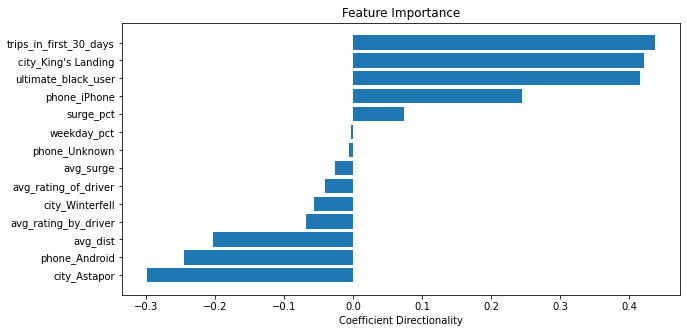

In [1452]:
# plot feature importance scores(coefficients), ordered by importance

scores_ = np.array(pipe_steps.coef_[0])
sorted_idx = np.argsort(scores_)

# make plots 
pos = np.arange(sorted_idx.shape[0])
sorted_idx.size
plt.figure(figsize=(10,5))
plt.barh(pos, scores_[sorted_idx], align='center')
plt.yticks(pos, df_numeric.columns[sorted_idx])
plt.xlabel('Coefficient Directionality')
plt.title('Feature Importance')
plt.show()

According to our logistic regression model we can see that 'trips in first 30 days', 'city King's Landing', and 'ultimate black user' are highly and positively correlated with a user being retained (or 'active'). 'iPhone user' and 'surge percent' are also positively correlated but to a lesser degree. 'city Astapor', 'Andriod user' and 'average distance' are all negatively correlated with retention. 

# Modeling with Random Forest Classifier 

In [382]:
# import the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# import permutation feature importance function 
from sklearn.inspection import permutation_importance

In [1503]:
# instantiate model
rfc = RandomForestClassifier()

# create pipeline
pipeline = Pipeline([('scaler', StandardScaler()),('rfc', rfc)])

In [1511]:
# Hyperparameter tuning with Grid Search

params = {'rfc__bootstrap': [True, False],
        'rfc__max_depth': [10, 15, 20, 25],
        'rfc__max_features': ['auto', 'sqrt'],
        'rfc__min_samples_leaf': [3, 5, 7, 9],
        'rfc__min_samples_split': [1, 2, 5, 10],
        'rfc__n_estimators': [25, 50, 75, 100]}

rfc_gscv = GridSearchCV(pipeline, params, cv=5, verbose=True, n_jobs=-1, scoring='accuracy')

rfc_gscv.fit(X_train, y_train)

print("best parameters: ",rfc_gscv.best_params_)
print(f'Training accuracy score from tuned model: {rfc_gscv.best_score_*100:.1f}%')

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits
best parameters:  {'rfc__bootstrap': True, 'rfc__max_depth': 15, 'rfc__max_features': 'auto', 'rfc__min_samples_leaf': 5, 'rfc__min_samples_split': 10, 'rfc__n_estimators': 100}
Training accuracy score from tuned model: 78.5%


In [1526]:
# evaluate predictions from Grid Search tuning 

# predict class for X
y_pred = rfc_gscv.predict(X_test)

# generate accuracy and f1 scores
evaluate(y_test, y_pred)

Accuracy Score = 0.789
F1 Score = 0.785
Precision = 0.78
Recall = 0.762


With our Grid Search hyerparameter tuning method we achieve an accuracy score of 79%, which is better than our logistic regression model. 

In [1533]:
# Hyperparameter tuning with Random Search 

params = {'rfc__bootstrap': [True, False],
        'rfc__max_depth': [10, 15, 20, 25, 30],
        'rfc__max_features': ['auto', 'sqrt'],
        'rfc__min_samples_leaf': [1, 2, 4],
        'rfc__min_samples_split': [2, 5, 10],
        'rfc__n_estimators': [25, 50, 75, 100, 150]}


rfc_rscv = RandomizedSearchCV(pipeline, param_distributions=params, cv=5, verbose=True, random_state=13)

rfc_rscv.fit(X_train, y_train)

print(f'Best parameters: {rfc_rscv.best_params_}')
print(f'Training accuracy score from tuned model: {rfc_rscv.best_score_*100:.1f}%')
print('')

# predict class for X
y_pred = rfc_rscv.predict(X_test)

# generate accuracy scores
evaluate(y_test, y_pred)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'rfc__n_estimators': 100, 'rfc__min_samples_split': 2, 'rfc__min_samples_leaf': 4, 'rfc__max_features': 'sqrt', 'rfc__max_depth': 15, 'rfc__bootstrap': True}
Training accuracy score from tuned model: 78.3%

Accuracy Score = 0.790
F1 Score = 0.786
Precision = 0.781
Recall = 0.763


With random hyperparameter tuning we also get an accuracy score of 79%.   

In [1469]:
# create function for evaluating and plotting feature importance

def feature_metrics(model_object, pipe_model_name, title, perm=False):

    # generate permutation feature importance if desired (perm=True)
    if perm == True:
        perm_imp = permutation_importance(model_object, X_train, y_train, n_repeats=10, random_state=22)
        mean_imp = [v for k,v in perm_imp.items() if k == 'importances_mean']
        feature_importance = mean_imp[0]

    # generate GINI importance metric
    else:
        feature_importance = model_object.best_estimator_.named_steps[pipe_model_name].feature_importances_

    # create list of feature name and importance score 
    rounded_feat = [round(x,2) for x in feature_importance]
    feat_imp = list(zip(df_numeric.columns[:-1],rounded_feat))

    # print list of features and their importance as a proportion of the total importance
    print('Features and their proportional importance:')
    for i in feat_imp:
        print(i[0], '=', int(i[1]*100), '%')
    
    # make plots
    sorted_idx = np.argsort(feature_importance) 
    pos = np.arange(sorted_idx.shape[0]) 
    sorted_idx.size
    plt.figure(figsize=(15,5))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, df_numeric.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title(title)
    plt.show()

Features and their proportional importance:
trips_in_first_30_days = 7 %
avg_rating_of_driver = 5 %
avg_surge = 9 %
surge_pct = 11 %
ultimate_black_user = 5 %
weekday_pct = 12 %
avg_dist = 11 %
avg_rating_by_driver = 17 %
city_Astapor = 3 %
city_King's Landing = 10 %
city_Winterfell = 2 %
phone_Android = 4 %
phone_Unknown = 0 %
phone_iPhone = 4 %


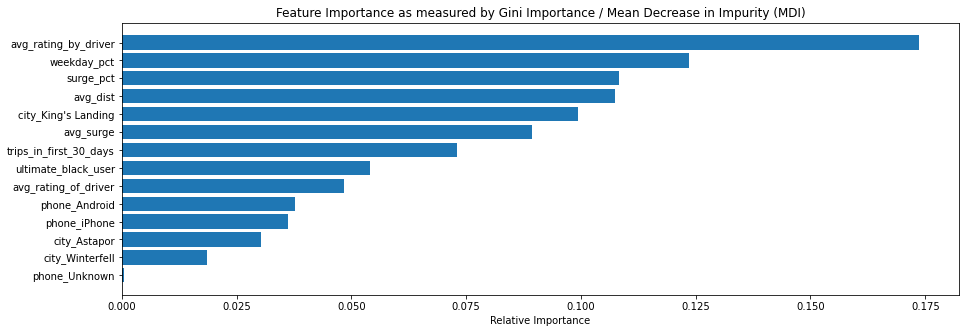

In [1539]:
# GINI feature importance for Random Forest 

feature_metrics(rfc_gscv, 'rfc', 'Feature Importance as measured by Gini Importance / Mean Decrease in Impurity (MDI)')

Features and their proportional importance:
trips_in_first_30_days = 3 %
avg_rating_of_driver = 2 %
avg_surge = 2 %
surge_pct = 2 %
ultimate_black_user = 3 %
weekday_pct = 5 %
avg_dist = 3 %
avg_rating_by_driver = 6 %
city_Astapor = 2 %
city_King's Landing = 5 %
city_Winterfell = 1 %
phone_Android = 1 %
phone_Unknown = 0 %
phone_iPhone = 1 %


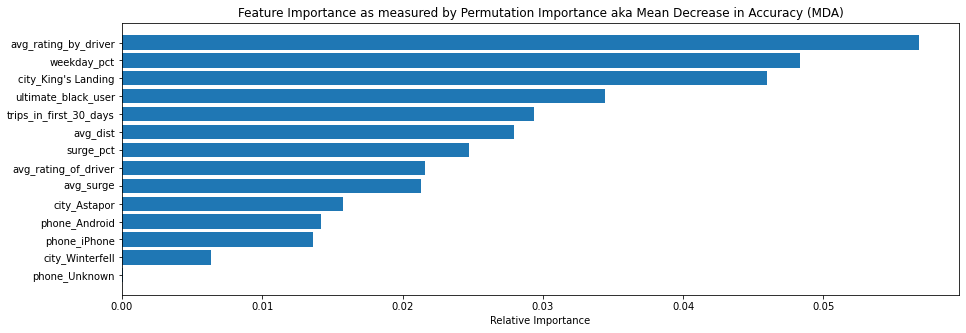

In [1540]:
# Permutation feature importance for Random Forest 

feature_metrics(rfc_gscv, 'rfc', 'Feature Importance as measured by Permutation Importance aka Mean Decrease in Accuracy (MDA)', perm=True)

Above we compared two methods of calculating feature importance. The default feature importance calculation in SkLearn is known as GINI or Mean Decrease in Impurity. This method has been shown to have some pitfalls as it has the potential to be skewed by features with high cardinality like numeric/continuous features. Because there are more unique values with continuous variables they end up being used more in decision trees and can thus take on more 'weight' when evaulating feature importance.

The permutation method can help provide another perspective on feature importance. It helps prevent the discounting of binary (low cardinalty) features when determining importance. 

We notice that both methods place 'average rating by driver' as the most important feature followed by 'percent of trips taken on weekdays'. However permutation importance lists 'King's Landing city' and 'ultimate black user' as the next two most important features. These are both binary (or categorical, 1 or 0) features, so this makes sense considering how permutation importance works. The GINI importance however lists 'surge percent' and 'average distance' as the third and forth most important features. This makes sense becuase they are both highly cardinal.

Overall both of these evaluations tell us 'average rating by driver' and 'percentage of trips on weekdays' are import features. Let's plot those two features below to see if we can visualize and relationship between the feature and our dependent variable.

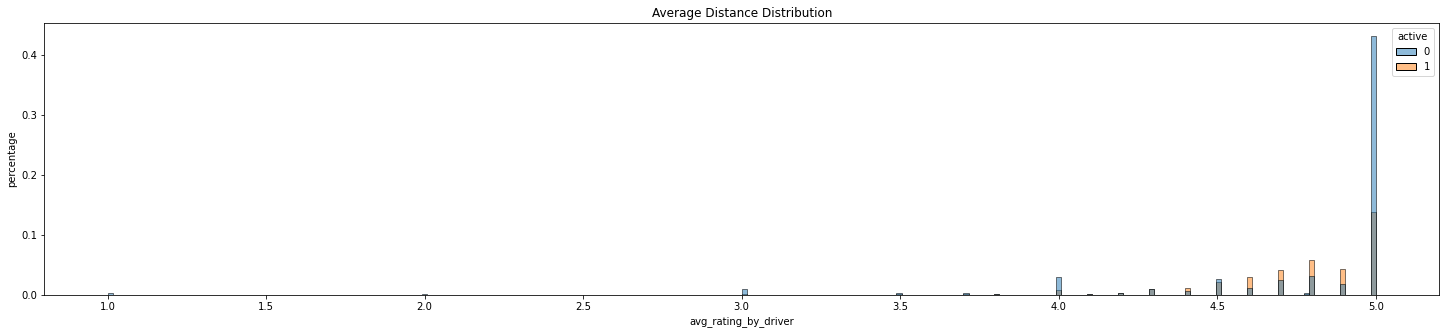

In [1545]:
# plot the 'average rating by driver' distrubution of our dataset to see if we can spot a correltaion 

fig, ax = plt.subplots(figsize=(25,5))
ax = sns.histplot(x='avg_rating_by_driver', data=df_numeric, hue='active', stat = 'probability')
ax.set(xlabel= 'avg_rating_by_driver', ylabel= 'percentage', title='Average Distance Distribution')
plt.show()

There appears to be a *negative* correlation between rating by driver and retention. Our linear regression coefficients also reflected this. This could possibly be explained by .. the more someone rides the more likely they are to have a mishap or poor interaction with the driver. The vast majority of ratings are still above 3.0 which suggests there aren't many *horrible* interactions. 

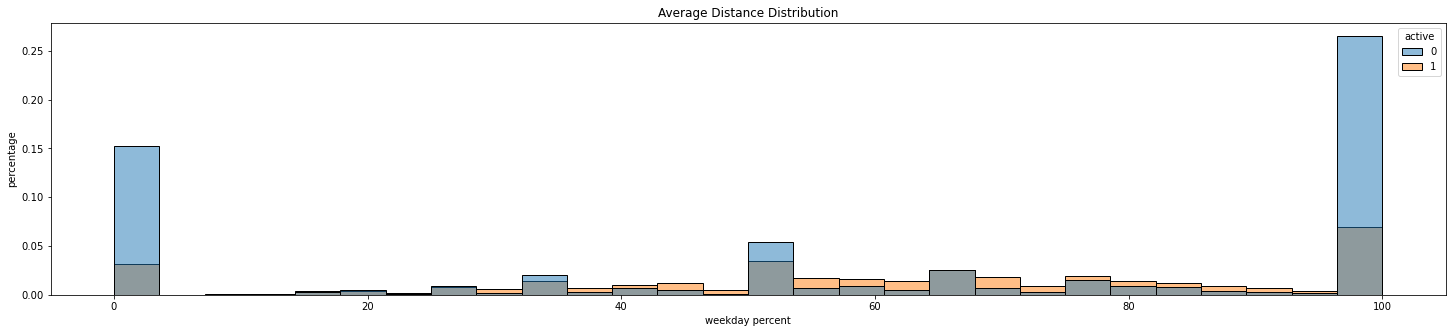

In [1551]:
# plot the 'weekday_pct' distrubution of our dataset to see if we can spot a correltaion 

fig, ax = plt.subplots(figsize=(25,5))
ax = sns.histplot(x='weekday_pct', data=df_numeric, hue='active', stat = 'probability')
ax.set(xlabel= 'weekday percent', ylabel= 'percentage', title='Average Distance Distribution')
plt.show()

This plot is interesting. There appears to be a normal distribution amongst retained (active) users and the percentage of their trips that occur on weekdays. Perhaps this points to a relationship between regular usage of the service and retention. Inactive users are much more splot between either 0% or 100% of trips occuring during weekdays. 

# Modeling with Gradient Boosting 

In [576]:
import xgboost as xgb

XGBoost in SKLearn pipeline

In [1495]:
#create pipeline

boost_pipe = Pipeline([('scaler', StandardScaler()), ('xgclass', xgb.XGBClassifier())])

In [1496]:
# pipline with Grid Search

parameters = {
     "xgclass__eta"    : [0.10, 0.15, 0.20, 0.25] ,
     "xgclass__max_depth"        : [ 4, 5, 6, 8],
     "xgclass__min_child_weight" : [ 1, 3, 5, 7 ],
     "xgclass__gamma"            : [ 0.1, 0.2 , 0.3, 0.4 ],
     "xgclass__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
  }

boost_gscv = GridSearchCV(boost_pipe, parameters, cv=5, verbose=True, n_jobs=-1, scoring='accuracy')

boost_gscv.fit(X_train, y_train)

print("best parameters: ", boost_gscv.best_params_)
print(f'Training accuracy score from tuned model: {boost_gscv.best_score_*100:.1f}%')

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits
best parameters:  {'xgclass__colsample_bytree': 0.4, 'xgclass__eta': 0.2, 'xgclass__gamma': 0.2, 'xgclass__max_depth': 6, 'xgclass__min_child_weight': 1}
Training accuracy score from tuned model: 79.1%


In [1497]:
# predict class for X
y_pred = boost_gscv.predict(X_test)

# generate accuracy scores
evaluate(y_test, y_pred)

Accuracy Score = 0.795
F1 Score = 0.792
Precision = 0.786
Recall = 0.77


We achieved a 79.5% accuracy score with XGBoost Grid Search hyperparameter tuning. Better than Random Forest, but not by much. 

In [1518]:
# pipeline with Random Search

parameters = {
     "xgclass__eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "xgclass__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "xgclass__min_child_weight" : [ 1, 3, 5, 7 ],
     "xgclass__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "xgclass__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
     "xgclass__learning_rate": [0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
  }

boost_rscv = RandomizedSearchCV(boost_pipe,
                    parameters, n_jobs=4,
                    scoring="accuracy",
                    cv=5)

boost_rscv.fit(X_train, y_train)

print("Best parameters:", boost_rscv.best_params_)
print("Best Score:", boost_rscv.best_score_)

Best parameters: {'xgclass__min_child_weight': 1, 'xgclass__max_depth': 5, 'xgclass__learning_rate': 0.3, 'xgclass__gamma': 0.3, 'xgclass__eta': 0.2, 'xgclass__colsample_bytree': 0.3}
Best Score: 0.7886


In [1520]:
# predict class for X
y_pred = boost_rscv.predict(X_test)

# generate accuracy scores
evaluate(y_test, y_pred)

Accuracy Score = 0.808
F1 Score = 0.805
Precision = 0.801
Recall = 0.783


We achieved 80% accuracy with XGBoost Random Search hyperparameter tuning. A full percentage point better than Random Forest.

Time to evaluate feature importance.

Features and their proportional importance:
trips_in_first_30_days = 2 %
avg_rating_of_driver = 1 %
avg_surge = 7 %
surge_pct = 1 %
ultimate_black_user = 15 %
weekday_pct = 10 %
avg_dist = 1 %
avg_rating_by_driver = 7 %
city_Astapor = 5 %
city_King's Landing = 23 %
city_Winterfell = 5 %
phone_Android = 15 %
phone_Unknown = 0 %
phone_iPhone = 1 %


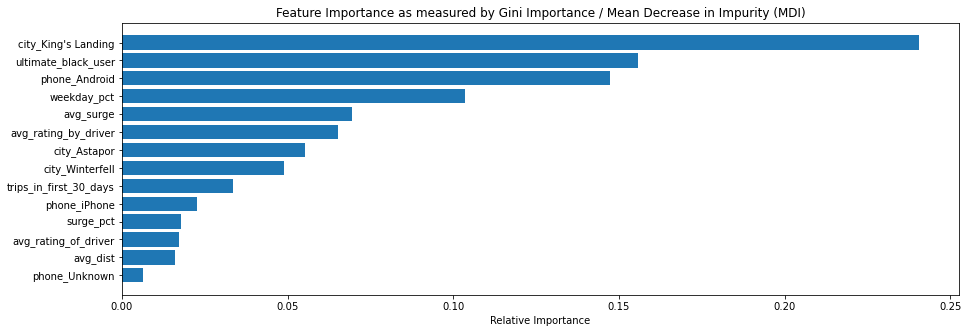

In [1549]:
feature_metrics(boost_rscv, 'xgclass', 'Feature Importance as measured by Gini Importance / Mean Decrease in Impurity (MDI)')

Features and their proportional importance:
trips_in_first_30_days = 2 %
avg_rating_of_driver = 1 %
avg_surge = 2 %
surge_pct = 1 %
ultimate_black_user = 2 %
weekday_pct = 4 %
avg_dist = 1 %
avg_rating_by_driver = 3 %
city_Astapor = 1 %
city_King's Landing = 3 %
city_Winterfell = 0 %
phone_Android = 1 %
phone_Unknown = 0 %
phone_iPhone = 0 %


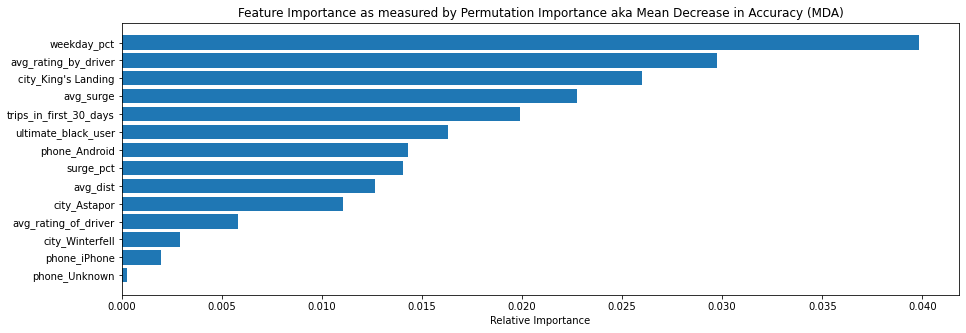

In [1537]:
feature_metrics(boost_rscv, 'xgclass', 'Feature Importance as measured by Permutation Importance aka Mean Decrease in Accuracy (MDA)', perm=True)

The GINI importance here favors 'King's Landing' by quite a decent margin. Followed by 'ultimate black user', 'Andriod user' and 'weekday percent'. 
Permutation Importance favors 'weekday percent', 'average rating by driver', 'King's Landing' and 'average surge'.

We can see that 'weekday percent' has shown up in the top 4 for both our Random Forest and our XGBoost models. This is intersting because the Logistic Regression coefficient indictated that this feature was pretty neutral in its predictive value. 

King's Landing as the city of residence is another feature that has continuously been identified as important. 



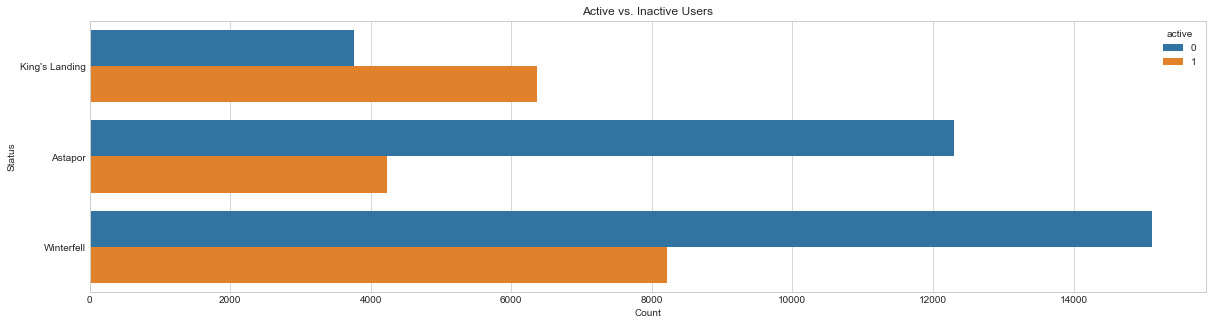

In [1573]:
# examine city columns 

df_with_city = pd.merge(df_numeric, df_user_info['city'], left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(20,5))
ax = sns.countplot(y="city", data=df_with_city, hue="active")
ax.set(xlabel= 'Count', ylabel= 'Status', title="Active vs. Inactive Users")
plt.show()

So we can see that there is a very disproportionate amount of reatianed (or 'active') users in King's Landing! In the entire dataset there's aabout 38% active users and 62% inactive users, whereas for King's Landing there's siginificantly more active than inactive users. I would recommend the company look into this and see if we can figure out what's special about King's Landing. 

## XGBoost with native .train() method as opposed to SkLearn .fit() method

In [1024]:
# scale the data 

scaler = StandardScaler()

X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [1205]:
# create DMatrix format
D_train = xgb.DMatrix(X_train_scaled, label=y_train)
D_test = xgb.DMatrix(X_test_scaled, label= y_test)

In [1576]:
# employ best parameters from previous random search

parameters = {'min_child_weight': 1, 
            'gamma': 0.3, 
            'colsample_bytree': 0.5, 
            'eta': 0.1, 
            'max_depth': 8,  
            'objective': 'multi:softprob',  
            'num_class': 9}

steps = 40

model = xgb.train(parameters, D_train, steps)

preds = model.predict(D_test)

best_preds = np.asarray([np.argmax(line) for line in preds])

#print accuracy scores 
evaluate(y_test, best_preds)

# plot feature importance 
# plt.figure(figsize=(16, 12))
# xgb.plot_importance(model, importance_type='weight')
# plt.title('weight')
# xgb.plot_importance(model, importance_type='gain')
# plt.title('gain')
# plt.show()


Accuracy Score = 0.795
F1 Score = 0.791
Precision = 0.786
Recall = 0.769


Using the XGB train method we achieve a similar accuracy score as the previous implementation of XGBoost, 79.5%

In [1574]:
# calculate feature importance score 

imp_dict = model.get_score(importance_type='gain')

14


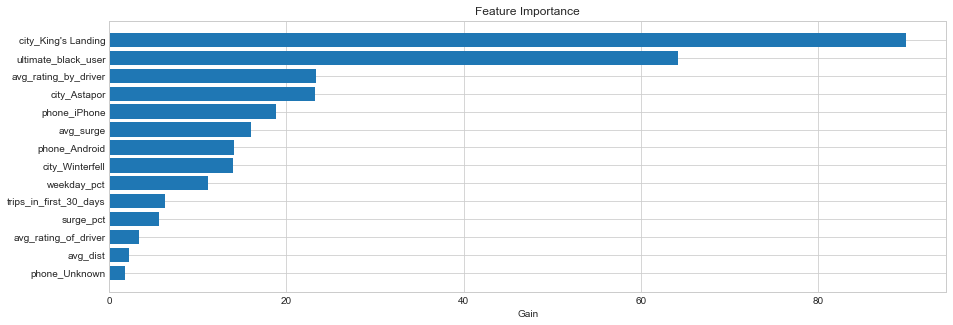

In [1575]:
# wrangling the output (dictionary) of model.get_score() into a list ordered by columns in dataframe 

# turn dictionary into list of tuples
results = [(k, v) for k,v in imp_dict.items()]

# unpack tuples into long list
features_ = []
results.sort()
for i in results:
    features_ += i

# get rid of the 'f' at the beginning of the feature number
for ind, i in enumerate(features_):
    if type(i) == str:
        features_[ind] = i[1:] 

# convert feature number from a string to a float, so they cam be numerically sorted        
for i in range(0, len(features_)):
    features_[i] = float(features_[i])

# repack long list back into list of feature/value pairs (as tuples)
it = iter(features_)
score_tup = list(zip(it, it))

# sort list of tuples by feature number, which will then correlate to the columns in our dataframe 
score_tup.sort()

# create list of importance scores ONLY, but still ordered by features in df 
gain_scores = []
for i in score_tup:
    gain_scores.append(i[1])


# plot feature importance scores, ordered by importance
scores_ = np.array(gain_scores)
sorted_idx = np.argsort(scores_)

# make plots 
pos = np.arange(sorted_idx.shape[0])
print(pos.size)
sorted_idx.size
plt.figure(figsize=(15,5))
plt.barh(pos, scores_[sorted_idx], align='center')
plt.yticks(pos, df_numeric.columns[sorted_idx])
plt.xlabel('Gain')
plt.title('Feature Importance')
plt.show()

Using XGBoost's .get_score medthod we generated feature importance scores. We used the setting 'gain' to calculate feature importance. The gain is a measure of how much gain in accuracy a feature contributed on average across all splits in the tree. 

We can see that 'King's Landing' unsurprisingly lands atop the importance list. Followed by 'ultimate black user', which has presented itself high up in previous importance rankings. 

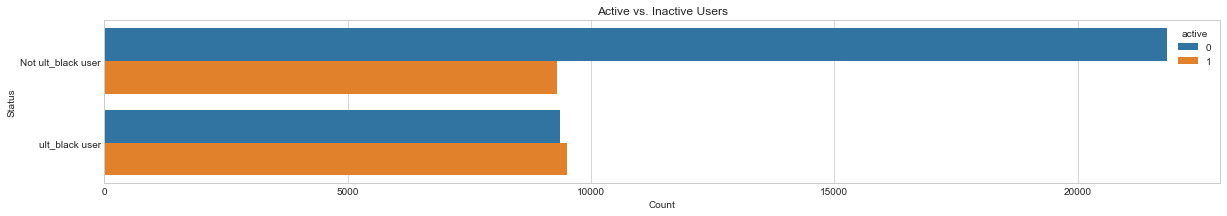

In [1580]:
fig, ax = plt.subplots(figsize=(20,3))
ax = sns.countplot(y="ultimate_black_user", data=df_with_city, hue="active")
ax.set(xlabel= 'Count', ylabel= 'Status', title="Active vs. Inactive Users")
ax.set_yticklabels(['Not ult_black user', 'ult_black user' ])
plt.show()

We can see that for people who are ultimate balck users about half of them are retained and half aren't. For people who are not ultimate black users the proportion of active and inactive is more representative of our overall dataset. We can conclude that being an ultimate black user matters for predicting retention. 

In [ ]:
# let's use the SHAP library to evaluate feature importance 

import shap

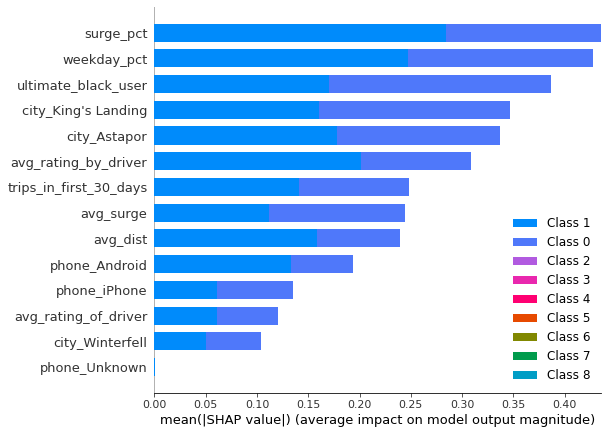

In [1550]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

Shaply Additive Explanations are an approach to feature importance that provides the average marginal contribution of a feature value across all the possible combinations of features. The Shapley value is the average of all the marginal contributions to all possible coalitions (groups of features). 

The Shapply values here place 'surge_percent' atop the importance list closely followed by 'weekday_percent', with 'ultimate_black_user' and 'King's Landing city' coming in 3rd and forth. Percentage of trips with a surge multiplier > 1 is an interesting metric; this is the first feature importance calculation that had placed it first. The remaining 3 top four values are all familiar.

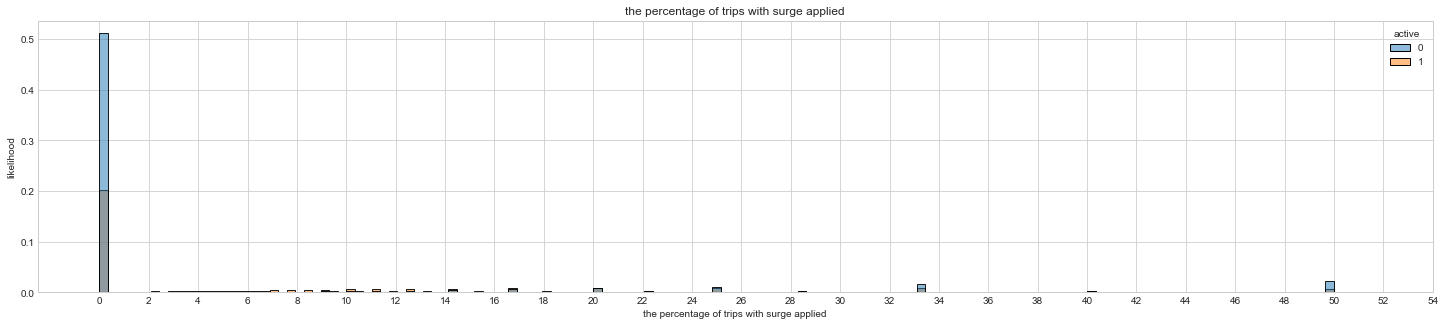

In [1595]:
df = df_numeric[df_numeric['surge_pct'] <= 50]


fig, ax = plt.subplots(figsize=(25,5))
ax = sns.histplot(x='surge_pct', data=df, hue='active', stat = 'probability')
ax.set(xlabel= 'the percentage of trips with surge applied', ylabel= 'likelihood', title='the percentage of trips with surge applied')
ax.set_xticks(np.arange(0, 56, step=2))
plt.show()

# Final Thoughts

Of all our models the Gradient Boosting ensemble method produced the best results, achieving an accuracy score of 80%. Each model type produced variations on feature importance ranking, but there was some notable consistency:

**King's Landing**: If a user lives in King's Landing they are far more likely to be retained. I would recommend the company look into the characteristics of this city to try and discover why. Has Ultimate run some type of promotion there? Or does it have to do with the economic, geographic, or political nature of that city? Depending on what we can learn about these cities, the company might want to look into increasing marketing in King's Landing to see if there is more market share to grab. On the other hand, we could also consider increasing marketing spend in Winterfell and Astapor to attract new customers.

**Weekday Percent**: Users with a higher percent (but not 100%) of trips taken on weekdays were more likely to be retained. This could reveal a correlation between people using the service for commuting and/or regular activity and continued use. It makes sense that if people have a routine of using Ultimate, they will be retained. I would recommend that the company run marketing campaigns presenting the service as a viable means of regular commuting. Ultimate could potentially begin an initiative to offer discounts to people who start using it to commute with the hope of that person continuing regular use after the initial discount ends. 

**Ultimate Black User**: This feature correlates to people using Ultimate's 'premium' service in the first 30 days. I would suspect there is a correlation between wealth and the ability to use the premium service. This could potentially reveal a correlation between income level and retention. Ride services do tend to be on the expensive side compared to public transit, so maybe this correlation influces what 'class' of people Ultimate markets to in the future. 

**Surge Percent**: This feature tells us that riders with a higher avergage amount of trips with a surge multiplier greater than 1 are more likely to be retained. This feature falls in line with 'weekday percent' and could indicate that people who use the service at rush hour are most likely commuting and thus more likely to use the service as part of their routine. 

**Average Rating by Driver**: The feature is pretty interesting as it's negatively correlated with retention. I belive that this could point to a phenomenon where the more often someone takes a ride the more likely they are to have a (somewhat) negative encounter with a driver and thus receive a lower rating. Also, if we know that daily commuters are using the service, someone may be in a worse mood or less likely to want to engage in friendly conversation with a driver. Sidenote: The average ratings were still typically above 3, so not *horrible* ratings. 

All in all we garnered some great takeaways. I believe many of the insights are actionable and could lead to potentially lucrative experiments. 